In [78]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

from torchvision import transforms, datasets
from sklearn.metrics import classification_report # f1
from torchmetrics.classification import MulticlassAccuracy # acc

from tqdm.auto import tqdm


In [79]:
EPOCHS = 3 # 1
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

In [80]:
# 데이터 경로
dataset_path = "datasets/project_datas/"

# duplication code만 적용한 데이터
TRAIN_DATA_PATH = dataset_path + "train/"
VALID_DATA_PATH = dataset_path + "valid/"
TEST_DATA_PATH = dataset_path + "test/"

# Normalize용 mean 및 std (ResNet50에서 학습할 때 다음 설정으로 했음)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# 학습용 transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# 학습용 transform (데이터 개수 늘리는 증강 적용할 때 사용)
aug_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])
aug_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# Norm 만 적용 (for valid, test)
initial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])


# Data load
# # 증강 방법 1 = 원본 이미지에 상하(p=0.5), 좌우(p=0.5), 밝기(0.2)적용
# train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transform)
# # 증강 방법 2 = 원본 이미지 + 상하반전(밝기0.2) + 좌우반전(밝기0.2)
# 증강 방법 2를 사용해서 학습 진행
train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=initial_transform)
train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform1)
train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform2)    

valid_data = datasets.ImageFolder(root=VALID_DATA_PATH, transform=initial_transform)
test_data = datasets.ImageFolder(root=TEST_DATA_PATH, transform=initial_transform)

train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

tensor([18, 22,  8, 14, 39,  7, 24,  2, 15,  2, 35, 22, 16, 20, 10, 15])
torch.Size([16, 3, 224, 224])

원본 이미지(norm 제거)


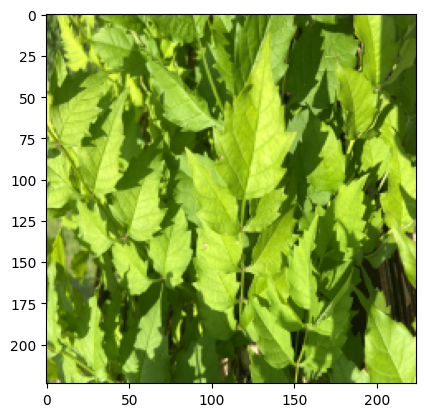

norm 적용 이미지


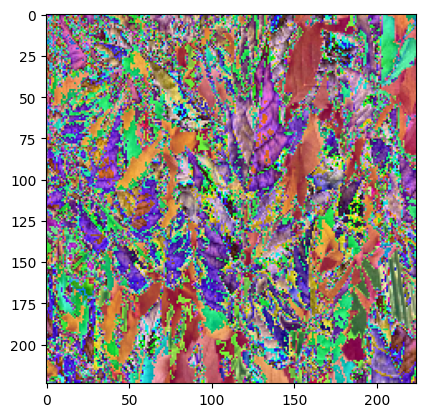

In [81]:
# data_loader의 이미지 및 shape, label 확인
topilimage = transforms.ToPILImage()
for img, label in train_data_loader:
    print(label)
    print(img.shape)
    remove_norm_img = topilimage(img[0]*torch.tensor(norm_std)[:, None, None] + torch.tensor(norm_mean)[:, None, None])
    normed_img = topilimage(img[0])
    
    print("\n원본 이미지(norm 제거)")
    plt.imshow(remove_norm_img)
    plt.show()
    
    print("norm 적용 이미지")
    plt.imshow(normed_img)
    plt.show()
    break

In [82]:
# 불러온 data class 순서, 개수 확인
class_dict = valid_data.class_to_idx
print(class_dict)

CLASS_NUM = len(class_dict)
print("Class 개수: ", CLASS_NUM)

# 꽃개오동 참취 곰취 개오동

# train, valid, test 개수 확인
print(f"train_num: {len(train_data)}\
      \nvalid_num: {len(valid_data)}\
      \ntest_num: {len(test_data)}")

{'가는장구채': 0, '가시박': 1, '가지': 2, '개여뀌': 3, '개오동': 4, '개옻나무': 5, '곰취': 6, '까마중': 7, '꽃개오동': 8, '능소화': 9, '닥풀': 10, '담배풀': 11, '대청부채': 12, '도깨비가지': 13, '독미나리': 14, '맑은대쑥': 15, '묏미나리': 16, '미국까마중': 17, '미국능소화': 18, '미나리': 19, '범부채': 20, '분홍장구채': 21, '붉나무': 22, '술패랭이꽃': 23, '아까시나무': 24, '어저귀': 25, '여뀌': 26, '여우오줌': 27, '왕자귀나무': 28, '자귀나무': 29, '장구채': 30, '제비쑥': 31, '좀담배풀': 32, '진득찰': 33, '쪽': 34, '참취': 35, '털진득찰': 36, '패랭이꽃': 37, '하늘타리': 38, '회화나무': 39}
Class 개수:  40
train_num: 90837      
valid_num: 4911      
test_num: 7516


In [83]:
# train device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# model load
# 사용한 모델 => https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="ResNet50_Weights.IMAGENET1K_V2")

# class 분류용 FC layer 추가
cf_fc1 = nn.Linear(1000, 512)
cf_fc2 = nn.Linear(512, CLASS_NUM)
model.add_module('CF_fc1', cf_fc1)
model.add_module('CF_fc2', cf_fc2)

## model GPU로 넘김
## Multi GPU: gpu 여러개일 때 DataParallel 사용, train 및 valid 부분도 수정해줘야함
# model = torch.nn.DataParallel(model).to(device) 
## Single GPU
model = model.to(device)

# optim 및 loss_func 설정        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss()

device:  cuda


Using cache found in C:\Users\kser/.cache\torch\hub\pytorch_vision_v0.10.0


In [84]:
# model 파라미터 및 구조 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

print(model)

26090064
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), st

In [85]:
# 학습 결과 저장 폴더 이름 및 경로 지정
save_path = 'model_save/train_2/'

if os.path.isdir(save_path) == True:
    print("!! 저장할 폴더와 동일한 이름의 폴더가 이미 존재합니다.")
else:
    print(f"{save_path} 경로에 저장 폴더가 생성되었습니다. ")
    os.makedirs(save_path)

!! 저장할 폴더와 동일한 이름의 폴더가 이미 존재합니다.


In [86]:
def train(model, trainloader, optimizer, loss_function, epoch, log_inter):
    model.train()
    # print(model)
    for batch_idx, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)
        # output = model.module.CF_fc(output) # DP사용할 때
        output = model.CF_fc1(output)
        output = model.CF_fc2(output)
        loss = loss_function(output, label)

        # Backward and optimize
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # Printing the result at the specific interval
        if batch_idx % log_inter == 0: # log_inter = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
            with open(save_path + 'Train_result.txt', 'a') as f:
                f.write("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\n".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
                
def valid(model, validloader, batch_size, loss_function):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        # 각 class별 f1-score 및 acc 계산용 array 저장
        all_pre = np.array([])
        all_lab = np.array([])
        
        for i, (image, label) in enumerate(tqdm(validloader)):
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            # 분류를 위한 FC layer 추가
            output = model.CF_fc1(output)
            output = model.CF_fc2(output)
            # output = model.module.CF_fc(output) # DP사용할 때
            
            valid_loss += loss_function(output, label).item()    
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                
            # 각 클래스별 f1-score 및 accuracy 계산을 위한 결과 저장
            tmp = prediction.squeeze(-1).cpu().numpy()
            tmp2 = label.cpu().numpy()
                
            # 모든 class의 f1-score 계산
            if all_pre.size == 0:
                all_pre = tmp
            else:
                all_pre = np.concatenate((all_pre, tmp))
            if all_lab.size == 0:
                all_lab = tmp2
            else:
                all_lab = np.concatenate((all_lab, tmp2))
    
    valid_loss /= (len(validloader.dataset) / batch_size)
    valid_accuracy = 100. * correct / len(validloader.dataset)
    return valid_loss, valid_accuracy, all_pre, all_lab

In [87]:
# model 저장용 valid_loss 설정
best_valid_loss = 100

# 전체 학습 진행
for epoch in range(0, EPOCHS):
    # train 학습 진행
    train(model, train_data_loader, optimizer, loss_function, epoch, log_inter = 2)
    
    # validation data에 대해서 평가
    valid_loss, valid_accuracy, all_pre, all_lab = valid(model, valid_data_loader, BATCH_SIZE, loss_function)
    
    # 각 클래스별 f1 score 계산 및 출력
    f1_scores = classification_report(all_lab, all_pre, digits=4)
    print(f1_scores)
    
    # 각 클래스별 accuracy 계산 및 출력
    compute_acc = MulticlassAccuracy(num_classes=CLASS_NUM, average=None)
    class_acc = compute_acc(torch.tensor(all_pre), torch.tensor(all_lab))
    print(class_acc)

    # val_loss 기준으로 best 모델을 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = f'epoch_{epoch}_val_{round(valid_loss, 2)}.pt'
        torch.save(model, save_path+best_model)

    # epoch마다 학습 결과를 파일로 저장
    with open(save_path + 'Train_result.txt', 'a') as f:
        f.write(f"\n[EPOCH: {epoch}/{EPOCHS}],\
            \nValid Loss: {valid_loss}, \
            \n\nf1-score:\n{f1_scores}, \
            \nclass_dict: {class_dict}, \
            \nclass_acc: {class_acc},\n \
            \nTotal Valid Accurcay: {valid_accuracy}%\n\n")        

Train Epoch: 0 [0/5678 (0%)]	Train Loss: 3.789177
Train Epoch: 0 [2/5678 (0%)]	Train Loss: 3.648311
Train Epoch: 0 [4/5678 (0%)]	Train Loss: 3.592664
Train Epoch: 0 [6/5678 (0%)]	Train Loss: 3.392400
Train Epoch: 0 [8/5678 (0%)]	Train Loss: 3.642877
Train Epoch: 0 [10/5678 (0%)]	Train Loss: 3.700733
Train Epoch: 0 [12/5678 (0%)]	Train Loss: 3.624511
Train Epoch: 0 [14/5678 (0%)]	Train Loss: 3.532052
Train Epoch: 0 [16/5678 (0%)]	Train Loss: 3.307360
Train Epoch: 0 [18/5678 (0%)]	Train Loss: 3.471535
Train Epoch: 0 [20/5678 (0%)]	Train Loss: 3.273172
Train Epoch: 0 [22/5678 (0%)]	Train Loss: 3.411747
Train Epoch: 0 [24/5678 (0%)]	Train Loss: 3.117224
Train Epoch: 0 [26/5678 (0%)]	Train Loss: 3.320932
Train Epoch: 0 [28/5678 (0%)]	Train Loss: 2.499956
Train Epoch: 0 [30/5678 (1%)]	Train Loss: 3.099895
Train Epoch: 0 [32/5678 (1%)]	Train Loss: 2.933918
Train Epoch: 0 [34/5678 (1%)]	Train Loss: 2.745034
Train Epoch: 0 [36/5678 (1%)]	Train Loss: 2.993026
Train Epoch: 0 [38/5678 (1%)]	Train 

100%|██████████| 307/307 [00:42<00:00,  7.15it/s]


              precision    recall  f1-score   support

           0     0.8468    0.8246    0.8356       114
           1     1.0000    0.8911    0.9424       101
           2     0.9951    0.9759    0.9854       622
           3     0.7586    0.8148    0.7857       108
           4     0.5034    0.8902    0.6432        82
           5     0.9673    0.8506    0.9052       174
           6     0.7566    0.9829    0.8550       117
           7     0.6939    0.9128    0.7884       149
           8     0.7115    0.3458    0.4654       107
           9     0.7980    0.8495    0.8229        93
          10     0.9734    0.9839    0.9786       186
          11     0.9130    0.5575    0.6923       113
          12     0.8378    0.5167    0.6392        60
          13     0.9565    0.9167    0.9362        96
          14     0.8636    0.7724    0.8155       123
          15     0.9612    0.7857    0.8646       126
          16     0.9053    0.9149    0.9101        94
          17     0.2941    

c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Train Epoch: 1 [4/5678 (0%)]	Train Loss: 0.143544
Train Epoch: 1 [6/5678 (0%)]	Train Loss: 0.246353
Train Epoch: 1 [8/5678 (0%)]	Train Loss: 0.166627
Train Epoch: 1 [10/5678 (0%)]	Train Loss: 0.060637
Train Epoch: 1 [12/5678 (0%)]	Train Loss: 0.092928
Train Epoch: 1 [14/5678 (0%)]	Train Loss: 0.482143
Train Epoch: 1 [16/5678 (0%)]	Train Loss: 0.180422
Train Epoch: 1 [18/5678 (0%)]	Train Loss: 0.151959
Train Epoch: 1 [20/5678 (0%)]	Train Loss: 0.068845
Train Epoch: 1 [22/5678 (0%)]	Train Loss: 0.042644
Train Epoch: 1 [24/5678 (0%)]	Train Loss: 0.139841
Train Epoch: 1 [26/5678 (0%)]	Train Loss: 0.061186
Train Epoch: 1 [28/5678 (0%)]	Train Loss: 0.135630
Train Epoch: 1 [30/5678 (1%)]	Train Loss: 0.591663
Train Epoch: 1 [32/5678 (1%)]	Train Loss: 0.113289
Train Epoch: 1 [34/5678 (1%)]	Train Loss: 0.279684
Train Epoch: 1 [36/5678 (1%)]	Train Loss: 0.197852
Train Epoch: 1 [38/5678 (1%)]	Train Loss: 0.032562
Train Epoch: 1 [40/5678 (1%)]	Train Loss: 0.016213
Train Epoch: 1 [42/5678 (1%)]	Trai

100%|██████████| 307/307 [00:42<00:00,  7.27it/s]
c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


              precision    recall  f1-score   support

           0     0.8509    0.8509    0.8509       114
           1     0.9604    0.9604    0.9604       101
           2     0.9967    0.9775    0.9870       622
           3     0.8444    0.7037    0.7677       108
           4     0.5766    0.9634    0.7215        82
           5     0.9486    0.9540    0.9513       174
           6     0.9268    0.9744    0.9500       117
           7     0.6474    0.6779    0.6623       149
           8     0.8846    0.4299    0.5786       107
           9     0.8148    0.9462    0.8756        93
          10     0.9418    0.9570    0.9493       186
          11     0.9804    0.4425    0.6098       113
          12     0.5588    0.9500    0.7037        60
          13     0.8900    0.9271    0.9082        96
          14     0.6766    0.9187    0.7793       123
          15     0.8618    0.8413    0.8514       126
          16     0.9610    0.7872    0.8655        94
          17     0.1250    

100%|██████████| 307/307 [00:42<00:00,  7.26it/s]

              precision    recall  f1-score   support

           0     0.8608    0.5965    0.7047       114
           1     0.9495    0.9307    0.9400       101
           2     0.9935    0.9823    0.9879       622
           3     0.8621    0.6944    0.7692       108
           4     0.6186    0.8902    0.7300        82
           5     0.8901    0.9310    0.9101       174
           6     0.8828    0.9658    0.9224       117
           7     0.5723    0.6644    0.6149       149
           8     0.8108    0.5607    0.6630       107
           9     0.9529    0.8710    0.9101        93
          10     0.9797    0.7796    0.8683       186
          11     0.9265    0.5575    0.6961       113
          12     0.4222    0.9500    0.5846        60
          13     0.7965    0.9375    0.8612        96
          14     0.8155    0.6829    0.7434       123
          15     0.8108    0.9524    0.8759       126
          16     0.9529    0.8617    0.9050        94
          17     0.1974    

In [88]:
# 학습된 model 불러오기
print("불러온 모델: ", save_path+best_model, "\n")
model = torch.load(save_path+best_model) ## 학습 진행 후 바로 best_model load
print(model)

불러온 모델:  model_save/train_2/epoch_0_val_0.69.pt 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0

In [89]:
# test dataset에 대한 평가 진행
test_loss, test_accuracy, all_pre, all_lab = valid(model, test_data_loader, BATCH_SIZE, loss_function)

print()
print(class_dict)
print()

compute_acc = MulticlassAccuracy(num_classes=CLASS_NUM, average=None)
class_acc = compute_acc(torch.tensor(all_pre), torch.tensor(all_lab))
        
print()
print("\nf1-scores...\n")
f1_scores = classification_report(all_lab, all_pre, digits=4)
print(f1_scores)

with open(save_path + 'Test_result.txt', 'a') as f:
    f.write(f"f1-score:\n{f1_scores} \
        \nclass_dict: {class_dict}, \
        \nclass_acc: {class_acc},\n \
        \nTotal Test Accurcay: {test_accuracy}%\n\n")

100%|██████████| 470/470 [01:04<00:00,  7.26it/s]


{'가는장구채': 0, '가시박': 1, '가지': 2, '개여뀌': 3, '개오동': 4, '개옻나무': 5, '곰취': 6, '까마중': 7, '꽃개오동': 8, '능소화': 9, '닥풀': 10, '담배풀': 11, '대청부채': 12, '도깨비가지': 13, '독미나리': 14, '맑은대쑥': 15, '묏미나리': 16, '미국까마중': 17, '미국능소화': 18, '미나리': 19, '범부채': 20, '분홍장구채': 21, '붉나무': 22, '술패랭이꽃': 23, '아까시나무': 24, '어저귀': 25, '여뀌': 26, '여우오줌': 27, '왕자귀나무': 28, '자귀나무': 29, '장구채': 30, '제비쑥': 31, '좀담배풀': 32, '진득찰': 33, '쪽': 34, '참취': 35, '털진득찰': 36, '패랭이꽃': 37, '하늘타리': 38, '회화나무': 39}



f1-scores...

              precision    recall  f1-score   support

           0     0.9205    0.9643    0.9419       168
           1     0.9936    0.9630    0.9781       162
           2     0.9911    0.9962    0.9937       786
           3     0.8743    0.9330    0.9027       179
           4     0.9571    0.8933    0.9241       150
           5     0.9431    0.9005    0.9213       221
           6     0.9157    0.9760    0.9449       167
           7     0.7479    0.9531    0.8381       277
           8     0.9728    0.9728    0.972